In [12]:
import pandas as pd
import joblib

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources only once
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def load_sentiment140_dataset(filepath: str, sample_size: float = 1.0) -> pd.DataFrame:
    """
    Load the Sentiment140 dataset from CSV and assign column names.

    Parameters:
        filepath (str): Path to the dataset CSV file.

    Returns:
        pd.DataFrame: Loaded DataFrame with renamed columns and binary sentiment labels.
    """
    # Define column names based on dataset documentation
    column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
    
    # Load CSV with proper encoding
    df = pd.read_csv(filepath, encoding='latin-1', header=None, names=column_names)
    if sample_size < 1.0:
        df = df.sample(frac=sample_size, random_state=42)

    # Map sentiment values: 0 -> negative, 4 -> positive
    df['target'] = df['target'].map({0: 0, 4: 1})
    
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1bit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1bit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Shape of dataset: (48000, 6)


,target,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem



Missing values per column:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Class distribution:
target
1    24007
0    23993
Name: count, dtype: int64


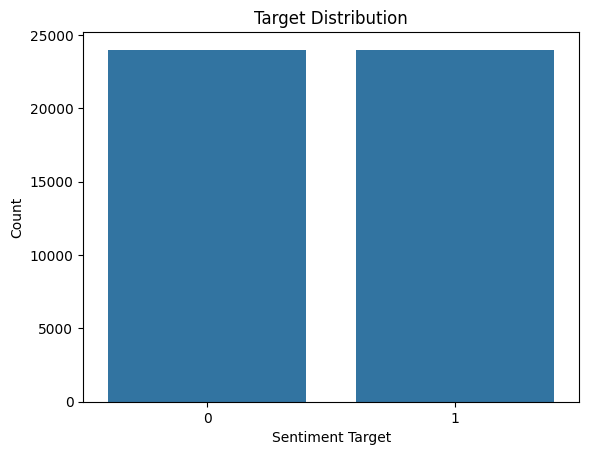

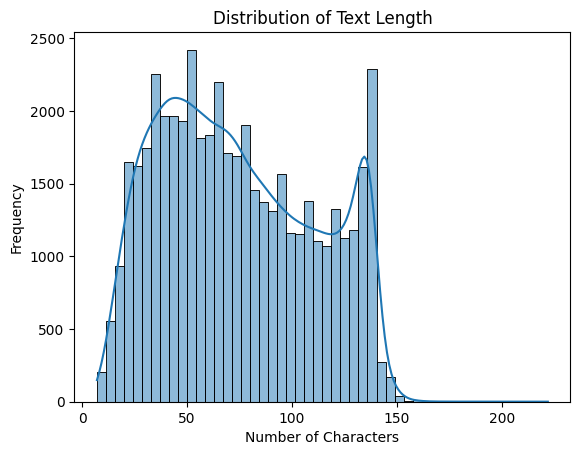

In [13]:
# Load your a sample of the dataset for showcase
df = load_sentiment140_dataset('data/training.1600000.processed.noemoticon.csv', 0.03)

# Quick shape and preview
print(f"Shape of dataset: {df.shape}")
display(df.head())

# Check for null values
print("\nMissing values per column:")
print(df.isnull().sum())

# Class distribution
print("\nClass distribution:")
print(df['target'].value_counts())

# Plot label distribution
sns.countplot(x='target', data=df)
plt.title("Target Distribution")
plt.xlabel("Sentiment Target")
plt.ylabel("Count")
plt.savefig("results/target_distribution.png")
plt.show()

# Text length distribution
text_lengths = df['text'].apply(len)
sns.histplot(text_lengths, bins=50, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.savefig("results/text_length_distribution.png")
plt.show()

In [14]:
def clean_tweet(text: str, lemmatizer: WordNetLemmatizer, stop_words: set) -> str:
    """
    Clean a tweet by removing noise and applying lemmatization.

    Parameters:
        text (str): Raw tweet text.
        lemmatizer (WordNetLemmatizer): NLTK lemmatizer instance.
        stop_words (set): Set of stopwords to exclude.

    Returns:
        str: Cleaned tweet.
    """
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)
    
    # Remove mentions and hashtags
    text = re.sub(r"@\w+|#\w+", "", text)
    
    # Remove numbers and punctuation
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize and lemmatize
    words = text.split()
    cleaned = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and len(word) > 1
    ]
    
    return " ".join(cleaned)


In [15]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Apply cleaning
df['clean_text'] = df['text'].apply(lambda x: clean_tweet(x, lemmatizer, stop_words))

# Preview before/after
df[['text', 'clean_text']].head()

,text,clean_text
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,ahhh hope ok
750,"@misstoriblack cool , i have no tweet apps fo...",cool tweet apps razr
766711,@TiannaChaos i know just family drama. its la...,know family drama lamehey next time hang kim g...
285055,School email won't open and I have geography ...,school email wont open geography stuff revise ...
705995,upper airways problem,upper airway problem


In [16]:
def vectorize_text(df: pd.DataFrame, max_features: int = 5000) -> tuple:
    """
    Convert the cleaned text into TF-IDF features.

    Parameters:
        df (pd.DataFrame): DataFrame containing the cleaned text column.
        max_features (int): Maximum number of features to keep based on TF-IDF score.

    Returns:
        tuple: TF-IDF transformed data (X) and corresponding labels (y).
    """
    # Initialize the TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=max_features)
    
    # Fit and transform the cleaned text
    X = vectorizer.fit_transform(df['clean_text'])
    
    # Get labels (sentiment)
    y = df['target']
    
    return X, y

X, y = vectorize_text(df)
# Check the shape of the resulting TF-IDF matrix
print(f"Shape of TF-IDF matrix: {X.shape}")

Shape of TF-IDF matrix: (48000, 5000)


In [17]:
# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (38400, 5000)
Test set size: (9600, 5000)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


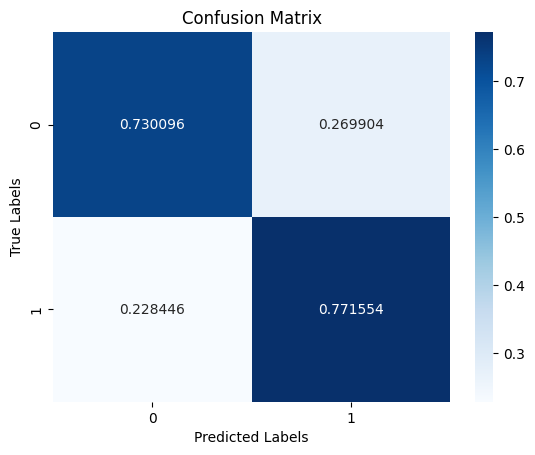

Accuracy on test set: 0.7508333333333334
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75      4798
           1       0.74      0.77      0.76      4802

    accuracy                           0.75      9600
   macro avg       0.75      0.75      0.75      9600
weighted avg       0.75      0.75      0.75      9600



In [18]:
# Initialize Logistic Regression
logreg = LogisticRegression(max_iter=1000)

# Hyperparameter grid for GridSearchCV (C, solver)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 200],
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(logreg,
                           param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='f1_macro',
                           verbose=2)
grid_search.fit(X_train, y_train)

# Save the model
joblib.dump(grid_search.best_estimator_, 'models/logreg_model_tuned.joblib')
# Best parameters from grid search
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("results/logreg_confusion_matrix.png")
plt.show()

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [19]:
# Initiaze SVM
svm = SVC(random_state=42)

# Hyperparameter grid for GridSearchCV (kernel, C, gamma)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Save the model
joblib.dump(grid_search.best_estimator_, 'models/svm_model_tuned.joblib')

# Best parameters from grid search
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("results/svm_confusion_matrix.png")
plt.show()

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
# Initiaze Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Hyperparameter grid for GridSearchCV (n_estimators, max_depth, min_samples_split, min_samples_leaf)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Save the model
joblib.dump(grid_search.best_estimator_, 'models/rf_model_tuned.joblib')

# Best parameters from grid search
print(f"Best parameters: {grid_search.best_params_}")

# Make predictions on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("results/rf_confusion_matrix.png")
plt.show()

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
